In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pypsa
import sys
import yaml

sys.path.append("../scripts/")
from plot_results import plot_dispatch, plot_emissions, plot_active_units

import warnings
warnings.filterwarnings('ignore')

c:\Users\JRuzekowicz\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# get config options
with open("../config.yml", "r") as file:
    config = yaml.safe_load(file)

First, we are going to load in the original model that is not working. This model tries to model 2025 with no extendable technology, no exportation of energy, and no emissions constraints enabled. It should demonstate that the current generators built should be able to supply the 2025 demand for energy without needing to expand the technology, which is the current plan. We believe this fails because there is too much generation that can not be ramped down (nuclear) when demand is low. This notebook aims to include a dummy "export generator" at each bus of the network that allows the model to balance supply and demand. This logically makes sense as IL is a net energy exporter. 

In [4]:
results_folder = f"{config['scenario']}_v{config['version']}"
results_folder

'no_growth_no_export_v3.0-test'

In [5]:
n = pypsa.Network(f"../results/{results_folder}/networks/illinois_solved.nc")

INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, lines, loads, storage_units


Here, we are going to look at which generators are not allowed to completely ramp down to 0% of theri capacity factor. We can see that the nuclear reactors have a minimum required output of 95% of their capacity factor. 

In [6]:
n.generators.loc[n.generators.p_min_pu > 0, 'p_min_pu']

Generator
MISO-Z4 LWR EXIST    0.95
ComEd LWR EXIST      0.95
MISO-Z4 LWR 2025     0.95
ComEd LWR 2025       0.95
Name: p_min_pu, dtype: float64

As seen when originally running the scripts, this will not solve as it is infeasible. Dispatching 95% of the capacity factor for the nuclear generators will result in some timestamps having more generator than demand, not allowing the model to be solved. 

In [7]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 23.73it/s]
INFO:linopy.io: Writing time: 2.0s
INFO:linopy.solvers:Log file at C:\Users\JRuzekowicz\AppData\Local\Temp\highs.log
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



('warning', 'infeasible')

To fix this, we will attempt to add "export generators" to the network at each bus. Thus, at every bus there is the opportunity to export electricity outside of IL in order to maintain an energy balance. 

In [8]:
for bus in n.buses.index:
    n.add(class_name="Generator",
                    name=f"{bus} Export",
                    bus=f"{bus}",
                    p_nom=1000000,
                    p_nom_min=0,
                    p_nom_extendable=True,
                    p_min_pu = -1,
                    p_max_pu = 0,
                    carrier="Export",
                    capital_cost=0,
                    marginal_cost=0,
                    lifetime=30,
                    ramp_limit_down = 0,
                    ramp_limit_up = 0,
                    build_year=2022,
                    )

Check to see if this generator was added to the network at each bus. 

In [9]:
n.generators

,bus,p_nom,p_nom_min,p_min_pu,carrier,marginal_cost,build_year,lifetime,capital_cost,ramp_limit_up,...,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MISO-Z4 Land-Based Wind EXIST,MISO-Z4,2768.8,2768.8,0.00,Wind,0.000000,2015,20.0,181002.457437,NaN,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 Utility PV EXIST,MISO-Z4,816.0,816.0,0.00,Solar,0.000000,2020,20.0,148474.218145,NaN,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
ComEd Land-Based Wind EXIST,ComEd,5133.1,5133.1,0.00,Wind,0.000000,2012,20.0,181002.457437,NaN,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
ComEd Utility PV EXIST,ComEd,416.6,416.6,0.00,Solar,0.000000,2020,20.0,148474.218145,NaN,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 CCAvgCF EXIST,MISO-Z4,702.1,0.0,0.00,Natural Gas,21.671800,2002,40.0,105805.789730,1.00,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 CTAvgCF EXIST,MISO-Z4,4196.0,0.0,0.00,Natural Gas,24.991800,1991,40.0,90604.192431,1.00,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 IGCCAvgCF EXIST,MISO-Z4,4310.6,0.0,0.00,Coal,37.055130,1987,50.0,526552.762053,0.40,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 LWR EXIST,MISO-Z4,1138.3,1138.3,0.95,Nuclear,5.370000,1987,80.0,163174.028185,0.04,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0
MISO-Z4 Petroleum EXIST,MISO-Z4,349.7,0.0,0.00,Petroleum,186.353980,1989,20.0,137247.008011,1.00,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0.0


In [11]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 26.32it/s]
INFO:linopy.io: Writing time: 2.04s
INFO:linopy.solvers:Log file at C:\Users\JRuzekowicz\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 155493 primals, 455471 duals
Objective: 8.49e+08
Solver model: available
Solver message: optimal



AttributeError: 'Model' object has no attribute 'objective_value'

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='timestep', ylabel='GW'>)

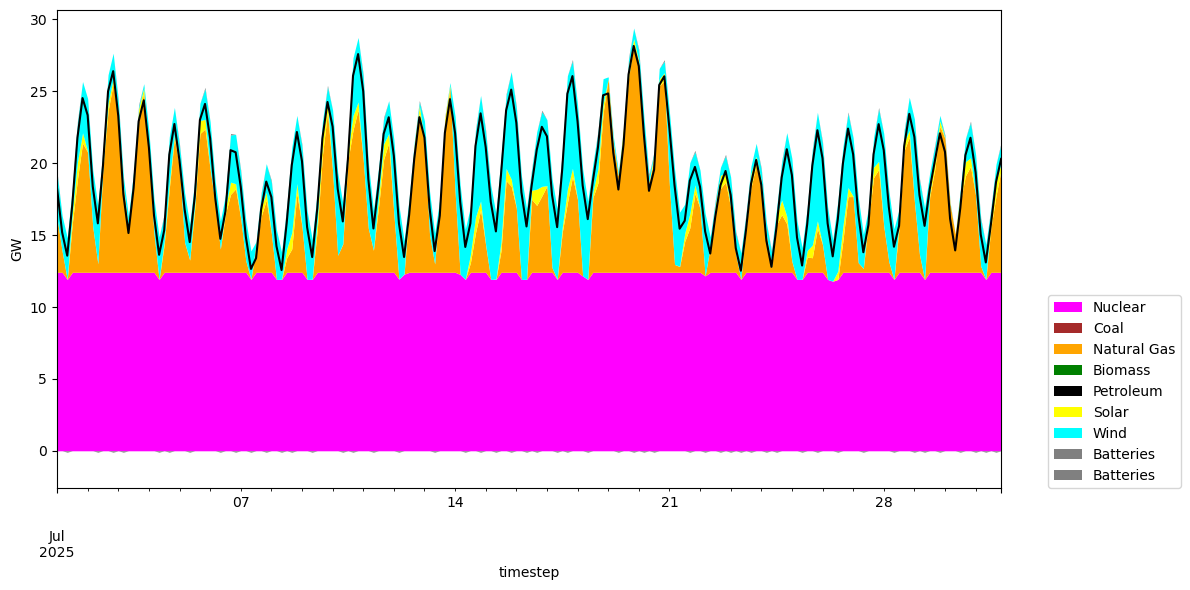

In [12]:
plot_dispatch(n)

In [13]:
n.statistics()

Optimal Capacity Installed Capacity Capacity Factor  \
                                    2025               2025            2025   
Generator   Biomass             0.000000                0.0             NaN   
            Coal             4310.600000             4310.6        0.000000   
            Export           1153.153848          2000000.0        1.000000   
            Natural Gas     18905.200000            18905.2        0.076651   
            Nuclear         12415.100000            12415.1        0.975383   
            Petroleum           0.000000                0.0             NaN   
            Solar            1232.600000             1232.6        0.153017   
            Wind             7901.900000             7901.9        0.370935   
Line        AC               7107.142883                0.0        0.613543   
StorageUnit Batteries          96.100000               96.1        0.386528   

                             Dispatch  Transmission    Withdrawal  \
                                 2025          2025          2025   
Generator   Biomass      0.000000e+00  0.000000e+00  0.000000e+00   
            Coal         0.000000e+00  0.000000e+00  0.000000e+00   
            Export      -1.010163e+07  0.000000e+00  1.010163e+07   
            Natural Gas  1.269412e+07  0.000000e+00  0.000000e+00   
            Nuclear      1.060790e+08  0.000000e+00  0.000000e+00   
            Petroleum    0.000000e+00  0.000000e+00  0.000000e+00   
            Solar        1.652212e+06  0.000000e+00  0.000000e+00   
            Wind         2.567633e+07  0.000000e+00  0.000000e+00   
Line        AC           0.000000e+00 -3.819834e+07  3.819834e+07   
StorageUnit Batteries    0.000000e+00  0.000000e+00  1.626968e+05   

                               Supply   Curtailment Capital Expenditure  \
                                 2025          2025                2025   
Generator   Biomass      0.000000e+00  0.000000e+00        0.000000e+00   
            Coal         0.000000e+00  0.000000e+00        2.269758e+09   
            Export       0.000000e+00  0.000000e+00        0.000000e+00   
            Natural Gas  1.269412e+07  0.000000e+00        1.804225e+09   
            Nuclear      1.060790e+08  0.000000e+00        2.025822e+09   
            Petroleum    0.000000e+00  0.000000e+00        0.000000e+00   
            Solar        1.652212e+06  2.368064e+05        1.830093e+08   
            Wind         2.567633e+07  1.223787e+07        1.430263e+09   
Line        AC           3.819834e+07  0.000000e+00        0.000000e+00   
StorageUnit Batteries    1.626968e+05  0.000000e+00        2.237419e+07   

                        Operational Expenditure Revenue Market Value  
                                           2025    2025         2025  
Generator   Biomass                0.000000e+00     0.0          0.0  
            Coal                   0.000000e+00     0.0          0.0  
            Export                 0.000000e+00     0.0          0.0  
            Natural Gas            2.794011e+08     0.0          NaN  
            Nuclear                5.696441e+08     0.0          NaN  
            Petroleum              0.000000e+00     0.0          0.0  
            Solar                  0.000000e+00     0.0          NaN  
            Wind                   0.000000e+00     0.0          NaN  
Line        AC                     0.000000e+00     0.0          NaN  
StorageUnit Batteries              0.000000e+00     0.0          NaN

In [17]:
n.generators.loc[n.generators.carrier == 'Export']

,bus,p_nom,p_nom_min,p_min_pu,carrier,marginal_cost,build_year,lifetime,capital_cost,ramp_limit_up,...,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MISO-Z4 Export,MISO-Z4,1000000.0,0.0,-1.0,Export,0.0,2022,30.0,0.0,0.0,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,1153.153848
ComEd Export,ComEd,1000000.0,0.0,-1.0,Export,0.0,2022,30.0,0.0,0.0,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,-0.000000
